In [1]:
from slim_gsgp_lib_np.main_slim import slim
from slim_gsgp_lib_np.utils.utils import train_test_split
from slim_gsgp_lib_np.utils.callbacks import *
from slim_gsgp_lib_np.evaluators.fitness_functions import rmse
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import time
import os
from tqdm import tqdm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.simplifiers import *
from slim_gsgp_lib_np.datasets.data_loader import *
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from slim_gsgp_lib_np.selection.selection_algorithms import tournament_selection_min

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

from slim_gsgp_lib_np.main_gp import gp
from slim_gsgp_lib_np.algorithms.GP.representations.tree import Tree

# -------------------------- # 
from slim_gsgp_lib_np.utils.utils import check_slim_version
# from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree import Tree
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition import Condition
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.population import Population    
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree_utils import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.mutators import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.xo import *

In [109]:
X, y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
seed = 10

elite, gp_pop = gp(X_train=X_train, y_train=y_train, full_return=True, test_elite=False, dataset_name='',
                       selector='tournament', n_iter=1000, pop_size=100, 
                       max_depth=8, init_depth=3, p_xo=0.8, down_sampling=0.8, seed=seed, verbose=0,
                       )

In [ ]:
from slim_gsgp_lib_np.utils.utils import (
        get_subtree,
        create_grow_random_tree,
        swap_sub_tree,
    )

from slim_gsgp_lib_np.algorithms.GP.representations.tree_utils import get_indices_with_levels


def mutate_tree_subtree_dc(max_depth, TERMINALS, CONSTANTS, FUNCTIONS, p_c, p_t):
    """
    Returns a function to perform subtree mutation with depth constraint.

    Parameters
    ----------
    max_depth : int
        Maximum depth of the resulting tree after mutation.
    TERMINALS, CONSTANTS, FUNCTIONS : dict
        Sets of elements allowed in the trees.
    p_c : float
        Probability of selecting a constant during random tree creation.
    p_t : float
        Probability of selecting a terminal during random tree creation.

    Returns
    -------
    Callable
        A mutation function that respects tree depth limits.
    """

    def inner_mut(tree1):
        if not isinstance(tree1, tuple):
            return tree1

        indices_with_levels = get_indices_with_levels(tree1)
        level = random.choice(list(indices_with_levels.keys()))
        index = random.choice(indices_with_levels[level])

        max_depth_new_subtree = max_depth - level - 1 

        if max_depth_new_subtree < 1:
            if random.random() < p_c: 
                new_subtree = random.choice(list(CONSTANTS.values()))
            else: 
                new_subtree = random.choice(list(TERMINALS.values()))

        else: 
            new_subtree = create_grow_random_tree(
                depth=max_depth_new_subtree,
                FUNCTIONS=FUNCTIONS,
                TERMINALS=TERMINALS,
                CONSTANTS=CONSTANTS,
                p_c=p_c,
                p_t=p_t,
            )

        return swap_sub_tree(tree1, new_subtree, list(index))

    return inner_mut

In [ ]:
mut_op = mutate_tree_subtree_dc(
    max_depth=8,
    TERMINALS=gp_pop[0].TERMINALS,
    CONSTANTS=gp_pop[0].CONSTANTS,
    FUNCTIONS=gp_pop[0].FUNCTIONS,
    p_c=0.7,
    p_t=0.7,
)

In [104]:
gp_pop[3].repr_

(np.str_('divide'), ('add', 'x62', 'x71'), ('add', 'x78', 'x21'))

In [105]:
mut_obj_1 = mut_op(gp_pop[3].repr_)
print(Tree(mut_obj_1).depth)
mut_obj_2 = mut_op(mut_obj_1)
print(Tree(mut_obj_2).depth)
mut_obj_3 = mut_op(mut_obj_2)
print(Tree(mut_obj_3).depth)
mut_obj_4 = mut_op(mut_obj_3)
print(Tree(mut_obj_4).depth)
mut_obj_5 = mut_op(mut_obj_4)
print(Tree(mut_obj_5).depth)

2
7
4
3
2


In [106]:
depths = []
for i in tqdm(range(10000)): 
    temp_tree = gp_pop[0].repr_
    for j in range(30): 
        temp_tree = mut_op(temp_tree)

    depth = Tree(temp_tree).depth
    depths.append(depth)

100%|██████████| 10000/10000 [00:03<00:00, 2698.41it/s]


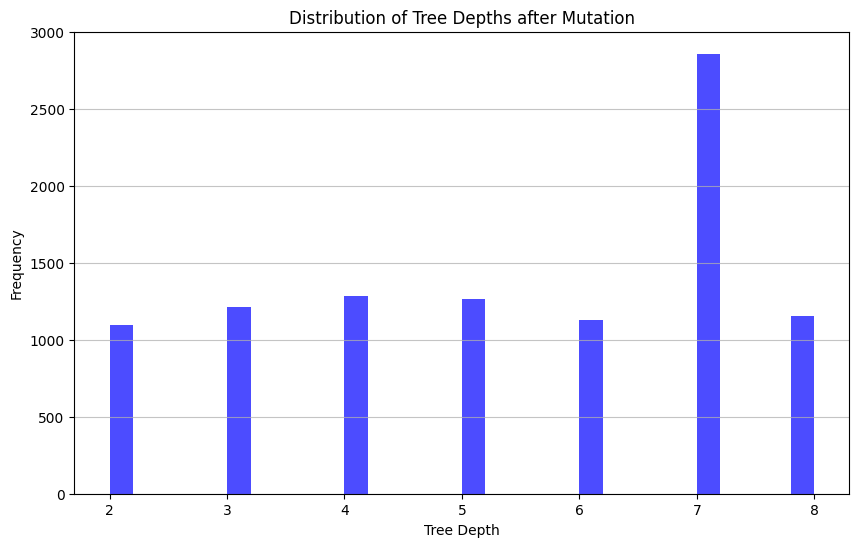

In [107]:
# Plot the distribution of depths
plt.figure(figsize=(10, 6))
plt.hist(depths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Tree Depths after Mutation')
plt.xlabel('Tree Depth')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
def mutate_tree_point(TERMINALS, CONSTANTS, FUNCTIONS, p_c, p_t):
    """
    Returns a function to perform point mutation on a tree.

    This mutation replaces a randomly selected node (function or terminal)
    with another of the same type and arity.

    Parameters
    ----------
    TERMINALS, CONSTANTS, FUNCTIONS : dict
        Sets of elements allowed in the trees.
    p_c : float
        Probability of choosing a constant for terminal mutation.
    p_t : float
        Probability of choosing a terminal (vs. function) for mutation.

    Returns
    -------
    Callable
        A mutation function that performs point mutation.
    """
    def inner_mut(tree1):
        if not isinstance(tree1, tuple):
            return tree1

        indices_with_levels = get_indices_with_levels(tree1)
        all_indices = [index for indices in indices_with_levels.values() for index in indices]
        index = random.choice(all_indices)
        subtree = get_subtree(tree1, list(index))

        # Point mutation depends on what kind of node we hit
        if isinstance(subtree, tuple):
            func, left, right = subtree
            # Replace with a different function (same arity)
            possible_funcs = [f for f in FUNCTIONS if f != func and FUNCTIONS[f][0] == FUNCTIONS[func][0]]
            if not possible_funcs:
                return tree1  # No replacement possible
            new_func = random.choice(possible_funcs)
            new_subtree = (new_func, left, right)

        else:
            # It's a terminal or constant
            if subtree in TERMINALS.values():
                possible_terms = [v for v in TERMINALS.values() if v != subtree]
                if not possible_terms:
                    return tree1
                new_terminal = random.choice(possible_terms)
                new_subtree = new_terminal
            elif subtree in CONSTANTS.values():
                possible_consts = [v for v in CONSTANTS.values() if v != subtree]
                if not possible_consts:
                    return tree1
                new_subtree = random.choice(possible_consts)
            else:
                # fallback: random terminal
                if random.random() < p_c:
                    new_subtree = random.choice(list(CONSTANTS.values()))
                else:
                    new_subtree = random.choice(list(TERMINALS.values()))

        return swap_sub_tree(tree1, new_subtree, list(index))

    return inner_mut


In [2]:
X, y = datasets[2]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
# X_train = MinMaxScaler().fit_transform(X_train)
# X_test = MinMaxScaler().fit_transform(X_test)
# y_train = MinMaxScaler().fit_transform(y_train.reshape(-1, 1)).ravel()
# y_test = MinMaxScaler().fit_transform(y_test.reshape(-1, 1)).ravel()

# X = np.random.rand(20, 2)
# y = np.random.rand(20)
# X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)

seed = 2

# agelog = LogAge()
# divlog = LogDiversity()
# early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train,
                    dataset_name='test', test_elite=False, slim_version='SLIM*ABS', # initializer='simple',
                    max_depth=15, init_depth=5, pop_size=100, n_iter=1000, seed=seed, verbose=1,
                    p_inflate=0.3, p_struct=0.3, n_cases=100,
                    prob_const=0.2, n_elites=1, selector='dalex', 
                    decay_rate=0.2, p_xo=0, p_struct_xo=0, prob_terminal=0.7,
                    # callbacks=[agelog, divlog, early_stop], 
                    mode='exp', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

for ind in population.population:
    ind.version = example_tree.version
    ind.train_semantics = ind.predict(X_train)
    ind.test_semantics = ind.predict(X_test)

FUNCTIONS = example_tree.collection[0].FUNCTIONS
TERMINALS = example_tree.collection[0].TERMINALS
CONSTANTS = example_tree.collection[0].CONSTANTS
SPECIALISTS = {f'S_{i}' : ind for i, ind in enumerate(population.population) if i<5}
Tree.FUNCTIONS = FUNCTIONS
Tree.TERMINALS = TERMINALS
Tree.CONSTANTS = CONSTANTS
Tree.SPECIALISTS = SPECIALISTS
Condition.FUNCTIONS = FUNCTIONS
Condition.TERMINALS = TERMINALS
Condition.CONSTANTS = CONSTANTS

AttributeError: 'SLIM_GSGP' object has no attribute 'lex_rounds_history'

In [3]:
collection = create_random_tree(2, 2, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS)
tree = Tree(collection)
print(tree.collection)

S_0


In [ ]:
pop = initializer(pop_size=100, 
            depth_condition=4, 
            max_depth=4, 
            FUNCTIONS=FUNCTIONS, 
            TERMINALS=TERMINALS, 
            CONSTANTS=CONSTANTS,
            SPECIALISTS=SPECIALISTS,
            p_c=0.3, 
            p_t=0.7, 
            p_specialist=0.5,
            )

pop = Population([Tree(struc) for struc in pop])
pop.calculate_semantics(X_train)
pop.evaluate(y_train, testing=False)

In [12]:
op = mutator(FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS, depth_condition=4, max_depth=4, p_c=0.3, p_t=0.5, decay_rate=0.2)

In [21]:
mdepth, mfit, mtotalnodes = [], [], []

population = pop

for it in range(50): 
    mean_depth = np.mean([i.depth for i in population.population])
    mean_total_nodes = np.mean([i.total_nodes for i in population.population])
    mean_fit = np.mean(population.fit)
    mdepth.append(mean_depth)
    mfit.append(mean_fit)
    mtotalnodes.append(mean_total_nodes)
    
    offs_pop = []
    for _ in range(100):
        p = tournament_selection_min(2)(population)
        o = op(p)
        offs_pop.append(o)
    
    population = Population(offs_pop)
    population.calculate_semantics(X_train)
    population.evaluate(y_train)

In [24]:
mfit

[np.float64(0.4816693425343406),
 np.float64(0.4708416734007354),
 np.float64(0.4583401215098046),
 np.float64(0.44275245886390197),
 np.float64(0.4429686835458817),
 np.float64(0.42596696390556427),
 np.float64(0.4295568652507828),
 np.float64(0.4367799430469715),
 np.float64(0.4465438183053853),
 np.float64(0.4462045754576743),
 np.float64(0.4428622062214434),
 np.float64(0.44239502752222504),
 np.float64(0.43668707723087336),
 np.float64(0.4283399216818847),
 np.float64(0.42340718613740663),
 np.float64(0.4338504878808482),
 np.float64(0.42999373128749613),
 np.float64(0.44091650007047956),
 np.float64(0.41336086402731254),
 np.float64(0.4181654876926605),
 np.float64(0.44155223183187375),
 np.float64(0.43951956253840363),
 np.float64(0.43742755294481533),
 np.float64(0.4391762159280573),
 np.float64(0.44128076168074953),
 np.float64(0.4543919520859761),
 np.float64(0.4518468816988967),
 np.float64(0.46559145394452045),
 np.float64(0.45545400824145427),
 np.float64(0.446493033485909

In [5]:
id1, id2 = pop[85], pop[60]
print(id1.depth, id2.depth)
o1, o2 = homologus_xo(id1, id2, 4)
print(o1.depth, o2.depth)

4 3
4 4


In [7]:
depths = {}
id1 = pop[60]
for _ in range(10000):
    o1 = op(id1)
    depth = o1.depth 
    if depth not in depths: 
        depths[depth] = 1
    else: 
        depths[depth] += 1

In [ ]:
id1 = pop[60]
print(id1.depth)
o1 = op(id1)
print(o1.depth, id1 == o1)

In [94]:
o1.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5890>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5790>,
  'S_2',
  'S_1'),
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb58d0>,
  'S_3',
  'S_2'))

In [95]:
id1.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5890>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5790>,
  'S_2',
  'S_1'),
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb58d0>,
  'S_3',
  'S_2'))

In [ ]:
idx_lev1 = get_indices_with_levels(i1)[1:]
idx_lev2 = get_indices_with_levels(i2)[1:]
idx_lev3 = get_indices_with_levels(i3)[1:]

print(idx_lev1)
print(idx_lev2)
print(idx_lev3)

[((), 0)]
[((1,), 1), ((1, 1), 2), ((1, 2), 2), ((2,), 1), ((2, 1), 2), ((2, 2), 2)]
[((1,), 1), ((1, 1), 2), ((1, 1, 1), 3), ((1, 1, 2), 3), ((1, 2), 2), ((1, 2, 1), 3), ((1, 2, 2), 3), ((2,), 1), ((2, 1), 2), ((2, 1, 1), 3), ((2, 1, 2), 3), ((2, 2), 2), ((2, 2, 1), 3), ((2, 2, 2), 3)]


In [301]:
max_depth1 = max([i for _,i in idx_lev1])
max_depth2 = max([i for _,i in idx_lev2])
max_depth3 = max([i for _,i in idx_lev3])

In [307]:
chosen_level1 = np.random.randint(1, max_depth1+1)
chosen_level2 = np.random.randint(1, max_depth2+1)
chosen_level3 = np.random.randint(1, max_depth3+1)

ValueError: low >= high

In [ ]:
chosen_level1 = np.random.randint(1, max_depth1+1)
chosen_level2 = np.random.randint(1, max_depth2+1)
chosen_level3 = np.random.randint(1, max_depth3+1)

path1 = random.choice(get_indices_with_levels(i1)[1:])[0]
path2 = random.choice(get_indices_with_levels(i2)[1:])[0]
path3 = random.choice(get_indices_with_levels(i3)[1:])[0]

sub1 = get_subtree(i1, path1)
sub2 = get_subtree(i2, path2)
sub3 = get_subtree(i3, path3)

print(sub1) 
print(sub2)
print(sub3)

S_2
S_1
(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE9249DD0>, (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE9248850>, 'S_3', 'S_3'), (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE92498D0>, 'S_2', 'S_3'))


In [ ]:
replace_subtree(i1, )

In [324]:
set([depth for _, depth in idx_lev2])

{1, 2}

In [339]:
level = random.choices(list(set([depth for _, depth in idx_lev2])))[0]
idx = random.choice([i for i, depth in idx_lev2 if depth == level])
print(idx)

(1,)


In [363]:
level = random.choices(list(set([depth for _, depth in idx_lev2])))[0]
idx = random.choice([i for i, depth in idx_lev2 if depth == level])

# Get the subtree of the tree.
subtree = get_subtree(i2, idx)
print(subtree)

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE928BD10>, 'S_1', 'S_4')


In [390]:
idx_lev1 = get_indices_with_levels(i2)[1:]
idx, level = uniform_level_choice(idx_lev1)
print(idx, level)
print(get_subtree(i2, idx))

(2,) 1
(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE928BD10>, 'S_1', 'S_4')


In [392]:
idx_lev1, idx_lev2 = get_indices_with_levels(i2)[1:], get_indices_with_levels(i3)[1:]
idx, depth = uniform_level_choice(idx_lev1)

In [395]:
[indices for indices, depth in idx_lev1 if depth == 2]

[(1, 1), (1, 2), (2, 1), (2, 2)]

In [ ]:
def uniform_level_choice(idx_lev):
    level = random.choices(list(set([depth for _, depth in idx_lev])))[0]
    idx = random.choice([i for i, depth in idx_lev if depth == level])
    return idx, level

def homologus_xo(ind1, ind2):    
    ind1, ind2 = ind1.collection, ind2.collection

    # Both are terminals; no crossover is possible.
    if isinstance(ind1, str) and isinstance(ind2, str):
        return ind1, ind2
    
    # One of them is a terminal; the terminal of one is replaced by the tree of the other. No depth restriction.
    elif isinstance(ind1, tuple) and isinstance(ind2, str):
        idx_lev1 = get_indices_with_levels(ind1)[1:]
        idx, _ = uniform_level_choice(idx_lev1)
        offs1 = get_subtree(ind1, idx)
        offs2 = replace_subtree(ind1, idx, ind2)
        
    elif isinstance(ind1, str) and isinstance(ind2, tuple):
        idx_lev2 = get_indices_with_levels(ind2)[1:]
        idx, _ = uniform_level_choice(idx_lev2)
        offs1 = get_subtree(ind2, idx)
        offs2 = replace_subtree(ind2, idx, ind1)

    # Both are tuples 
    else: 
        idx_lev1, idx_lev2 = get_indices_with_levels(ind1)[1:], get_indices_with_levels(ind2)[1:]
        idx_1, depth = uniform_level_choice(idx_lev1)
        same_depth = [indices for indices, d in idx_lev2 if d == depth]
        if same_depth: 
            idx_2 = random.choice(same_depth)
        else: 
            # The second parent has depth smaller than the first parent.
            # Uniform_level_choice isnt used to favor indices closer to depth (same functionality)
            idx_2 = random.choice([indices for indices, d in idx_lev2 if d < depth]) 
        
        tree_1 = get_subtree(ind1, idx_1)
        tree_2 = get_subtree(ind2, idx_2)
        offs1 = replace_subtree(ind1, idx_1, tree_2)
        offs2 = replace_subtree(ind2, idx_2, tree_1)

    return Tree(offs1), Tree(offs2)

In [523]:
a,b = crossover(pop[60],pop[33])

In [524]:
a.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe9289850>,
 'S_3',
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928bd10>,
  'S_1',
  'S_4'))

In [525]:
b.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe929b710>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928ae10>,
  'S_1',
  'S_2'),
 'S_2')

In [520]:
pop[60].collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe9289850>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928ae10>,
  'S_1',
  'S_2'),
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928bd10>,
  'S_1',
  'S_4'))

In [518]:
pop[33].collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe929b710>,
 'S_3',
 'S_2')

### ------------------------------------------------------------------------------------------------

In [364]:
struc = create_random_tree(3, 3, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS, p_specialist=0.7, p_t=0.7)
print(struc)

(('divide', 'x0', ('subtract', 'x1', 'x0')), 'S_0', 'S_2')


In [9]:
struc = create_random_tree(2, 1, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS)
tree = Tree(struc)
tree.evaluate(rmse, X_train, y_train, testing=False)
tree.evaluate(rmse, X_test, y_test, testing=True)   
tree.print_tree_representation()
print('------------------/-----------------')
print('Train RMSE (ensemble):', tree.fitness)
print('Test RMSE (ensemble):', tree.test_fitness)
print('Train RMSE (individual):', rmse(example_tree.predict(X_train), y_train))
print('Test RMSE (individual):', rmse(example_tree.predict(X_test), y_test))
print('------------------/-----------------')
print('Nodes:', tree.nodes_count)   
print('Total Nodes:', tree.total_nodes)


if (
  multiply(
    constant_0.41
    x0
  )
) > 0 then
  S_3
else
  S_2
endif

------------------/-----------------
Train RMSE (ensemble): 0.5768332842641796
Test RMSE (ensemble): 0.6984042546297496
Train RMSE (individual): 0.14272031425948212
Test RMSE (individual): 0.27550132633252133
------------------/-----------------
Nodes: 5
Total Nodes: 103


In [13]:
from slim_gsgp_lib_np.config.multi_slim_config import * 
slim_params = SlimParameters()